<a href="https://colab.research.google.com/github/harsha5428/LLM/blob/main/Assign3_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the necessary module to interact with Google Drive in Colab
from google.colab import drive
from google.colab import files
# Mount Google Drive to the Colab environment.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
!pip install datasets matplotlib seaborn pandas transformers torch vaderSentiment
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import torch
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

# Download NLTK data
nltk.download('punkt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Define a class for Climate Sentiment Analysis
class ClimateSentimentAnalysis:

    def __init__(self, model_dir=None):
        """
        Initialize the ClimateSentimentAnalysis class.
        This method loads the dataset, converts it to pandas DataFrames, and sets up the model directory.
        """
        # Load the dataset from the Hugging Face dataset library
        self.dataset_clim = load_dataset("climatebert/climate_detection")
        # Convert the train and test datasets to pandas DataFrames
        self.train_data_clim = self.dataset_clim["train"].to_pandas()
        self.test_data = self.dataset_clim["test"].to_pandas()
        # Initialize tokenizer and model as None; will be set later
        self.tokenizer = None
        self.model = None
        # Set the directory to save the model; use the provided directory or a default one
        self.model_dir = model_dir or './saved_model'

        # Create the model directory if it doesn't exist
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)
            print(f"Directory '{self.model_dir}' created.")
        else:
            print(f"Directory '{self.model_dir}' already exists.")

    def data_overview(self):
        """
        Print the shape (rows and columns) of the training and test datasets.
        """
        print("Train_Data_Shape:", self.train_data_clim.shape)
        print("Test_Data_Shape:", self.test_data.shape)

    def plot_class_distribution(self):
        """
        Plot the distribution of classes (labels) in the training data.
        """
        plt.figure(figsize=(8, 6))
        sns.countplot(x='label', data=self.train_data_clim)
        plt.title("Class Distribution in Training Data")
        plt.xlabel("Label")
        plt.ylabel("Count")
        plt.show()

    def plot_text_length_distribution(self):
        """
        Plot the distribution of text lengths in the training data.
        """
        # Calculate the length of each text and store it in a new column
        self.train_data_clim['text_len'] = self.train_data_clim['text'].apply(len)
        plt.figure(figsize=(8, 6))
        sns.histplot(self.train_data_clim['text_len'], bins=50)
        plt.title("Text Length Distribution in Training Data")
        plt.xlabel("Text Length")
        plt.ylabel("Frequency")
        plt.show()

    def generate_word_cloud(self):
        """
        Generate a word cloud for the training data, excluding stopwords.
        """
        # Tokenize all words in the training data
        all_words_clim = []
        for sentence in self.train_data_clim['text']:
            all_words_clim.extend(word_tokenize(sentence.lower()))

        # Define stopwords and additional symbols to exclude from the word cloud
        stopwords_clim = set(STOPWORDS)
        stopwords_clim.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}'])
        # Filter words to exclude stopwords and non-alphanumeric characters
        filtered_words = [word for word in all_words_clim if word not in stopwords_clim and word.isalnum()]

        # Generate frequency distribution of the filtered words
        freq_dist_clim = FreqDist(filtered_words)
        # Create and display the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist_clim)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Word Cloud for Training Data")
        plt.show()

    def generate_label_word_clouds(self):
        """
        Generate separate word clouds for texts labeled as discussing climate change and those that are not.
        """
        climate_words_clim = []
        non_climate_words_clim = []
        stopwords_clim = set(STOPWORDS)

        # Separate words into climate-related and non-climate-related based on labels
        for _, row in self.train_data_clim.iterrows():
            words = word_tokenize(row['text'].lower())
            if row['label'] == 1:
                climate_words_clim.extend(words)
            else:
                non_climate_words_clim.extend(words)

        # Create frequency distributions for both sets of words
        climate_freq_dist_clim = FreqDist([word for word in climate_words_clim if word not in stopwords_clim and word.isalnum()])
        non_climate_freq_dist_clim = FreqDist([word for word in non_climate_words_clim if word not in stopwords_clim and word.isalnum()])

        # Generate word clouds for both climate-related and non-climate-related texts
        climate_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(climate_freq_dist_clim)
        non_climate_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(non_climate_freq_dist_clim)

        # Display both word clouds side by side
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(climate_wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Word Cloud for Climate Change Discussions")

        plt.subplot(1, 2, 2)
        plt.imshow(non_climate_wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Word Cloud for Non-Climate Change Discussions")

        plt.show()

    def keyword_stats(self):
        """
        Analyze the occurrence of specific keywords in climate-related and non-climate-related texts.
        """
        # Define keywords to analyze
        terms_clim = ["climate", "warming", "emissions", "carbon", "energy", "sustainability"]

        # Calculate and print the percentage of texts containing each keyword, split by label
        for term in terms_clim:
            climate_term_count = sum(self.train_data_clim[self.train_data_clim['label'] == 1]['text'].str.lower().str.contains(term))
            non_climate_term_count = sum(self.train_data_clim[self.train_data_clim['label'] == 0]['text'].str.lower().str.contains(term))

            climate_percentage = (climate_term_count / len(self.train_data_clim[self.train_data_clim['label'] == 1])) * 100
            non_climate_percentage = (non_climate_term_count / len(self.train_data_clim[self.train_data_clim['label'] == 0])) * 100

            print(f"Keyword '{term}':")
            print(f"  - Appears in {climate_percentage:.2f}% of climate change texts")
            print(f"  - Appears in {non_climate_percentage:.2f}% of non-climate change texts")
            print("-" * 30)

    def analyze_sentiment(self):
        """
        Perform sentiment analysis on the training and test datasets and plot the results.
        """
        sentiment_analyzer_clim = SentimentIntensityAnalyzer()
        # Calculate sentiment scores for each text in the training and test data
        self.train_data_clim['sentiment'] = self.train_data_clim['text'].apply(lambda x: sentiment_analyzer_clim.polarity_scores(x)['compound'])
        self.test_data['sentiment'] = self.test_data['text'].apply(lambda x: sentiment_analyzer_clim.polarity_scores(x)['compound'])

        # Plot the distribution of sentiment scores in the training data
        plt.figure(figsize=(8, 6))
        sns.histplot(self.train_data_clim['sentiment'], bins=50)
        plt.title("Sentiment Distribution in Training Data")
        plt.xlabel("Sentiment Score")
        plt.ylabel("Frequency")
        plt.show()

        # Plot sentiment scores by label in the training data
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='label', y='sentiment', data=self.train_data_clim)
        plt.title("Sentiment by Label in Training Data")
        plt.xlabel("Label")
        plt.ylabel("Sentiment Score")
        plt.show()

    def categorize_and_analyze_sentiment(self):
        """
        Categorize sentiment into Positive, Negative, or Neutral and analyze its distribution by label.
        """
        # Function to categorize sentiment based on the score
        def sentiment_category(score):
            if score >= 0.05:
                return 'Positive'
            elif score <= -0.05:
                return 'Negative'
            else:
                return 'Neutral'

        # Apply the sentiment categorization to the training data
        self.train_data_clim['sentiment_cat'] = self.train_data_clim['sentiment'].apply(sentiment_category)

        # Calculate and print the proportions of sentiment categories for each label
        sentiment_proportions_clim = self.train_data_clim.groupby(['label', 'sentiment_cat'])['text'].count() / self.train_data_clim.groupby('label')['text'].count()
        print(sentiment_proportions_clim)

        # Plot the sentiment category proportions by label
        sentiment_proportions_clim.unstack().plot(kind='bar', figsize=(10, 6))
        plt.title("Sentiment Category Proportions by Label")
        plt.xlabel("Label (0: No Climate Change, 1: Climate Change)")
        plt.ylabel("Proportion")
        plt.legend(title="Sentiment Category")
        plt.show()

    def keyword_sentiment_analysis(self):
        """
        Analyze the relationship between specific keywords and sentiment in the training data.
        """
        terms = ["climate", "warming", "emissions", "carbon", "energy", "sustainability", "risk", "opportunity", "action", "crisis"]

        keyword_sentiment_df_clim = pd.DataFrame()
        # For each keyword, calculate the sentiment proportions for each label
        for term in terms:
            term_df = self.train_data_clim[self.train_data_clim['text'].str.lower().str.contains(term)]
            term_sentiment_counts = term_df.groupby(['label', 'sentiment_cat'])['text'].count()
            term_sentiment_proportions_clim = term_sentiment_counts / term_df.groupby('label')['text'].count()
            temp_df = term_sentiment_proportions_clim.unstack().fillna(0)
            temp_df['keyword'] = term
            keyword_sentiment_df_clim = pd.concat([keyword_sentiment_df_clim, temp_df])

        # Reshape the data for plotting
        keyword_sentiment_df_clim = keyword_sentiment_df_clim.reset_index().set_index(['keyword', 'label'])

        # Plot a heatmap to visualize the relationship between keywords and sentiment by label
        plt.figure(figsize=(12, 8))
        sns.heatmap(keyword_sentiment_df_clim, annot=True, cmap="YlGnBu", fmt=".2f")
        plt.title("Keyword-Sentiment Correlation Heatmap")
        plt.xlabel("Sentiment Category")
        plt.ylabel("Keyword (Label)")
        plt.show()

    def train_classifier(self):
        """
        Train a BERT-based classifier on the training data and save the model.
        """
        model_name = "bert-base-uncased"
        # Load pre-trained BERT model and tokenizer
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Tokenize the text data
        def tokenize_batch(batch):
            return self.tokenizer(batch["text"], truncation=True, padding="longest")

        tokenized_data = self.dataset_clim.map(tokenize_batch, batched=True)

        # Create a data collator for padding sequences to the same length
        data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)
        train_dataset_clim = tokenized_data["train"]
        test_dataset_clim = tokenized_data["test"]

        # Set training arguments
        training_args = TrainingArguments(
            output_dir=f'{self.model_dir}/results',
            evaluation_strategy="epoch",
            save_strategy="epoch",
            learning_rate=2e-5,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            num_train_epochs=5,
            weight_decay=0.01,
        )

        # Initialize the Trainer with the model, tokenizer, and training arguments
        trainer_clim = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset_clim,
            eval_dataset=test_dataset_clim,
            tokenizer=self.tokenizer,
            data_collator=data_collator,
            compute_metrics=self.compute_eval_metrics,
        )

        # Train the model
        trainer_clim.train()
        # Save the trained model
        trainer_clim.save_model(self.model_dir)
        print(f"Model saved at '{self.model_dir}'.")

    def compute_eval_metrics(self, predictions):
        """
        Compute evaluation metrics for the classifier, including accuracy, precision, recall, and F1-score.
        """
        label_ids = predictions.label_ids
        pred_ids = np.argmax(predictions.predictions, axis=1)
        accuracy = accuracy_score(label_ids, pred_ids)
        precision, recall, f1, _ = precision_recall_fscore_support(label_ids, pred_ids, average='weighted')
        return {
            'accuracy': accuracy,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }

    def evaluate_classifier(self):
        """
        Load the trained classifier and evaluate it on the test dataset, displaying the results and a confusion matrix.
        """
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_dir)
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_dir)

        def tokenize_batch(batch):
            return self.tokenizer(batch["text"], truncation=True, padding="longest")

        tokenized_test_data = self.dataset_clim["test"].map(tokenize_batch, batched=True)

        trainer_clim = Trainer(model=self.model)
        eval_results = trainer_clim.predict(tokenized_test_data)

        print(f"Evaluation Results: {eval_results.metrics}")

        predicted_labels = np.argmax(eval_results.predictions, axis=1)
        actual_labels = self.dataset_clim["test"]["label"]

        confusion_mat = confusion_matrix(actual_labels, predicted_labels)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=self.dataset_clim["test"].features["label"].names)
        cm_display.plot(cmap=plt.cm.Blues)
        plt.show()

    def predict_sample_sentiments(self, text_samples):
        """
        Use the trained classifier to predict the sentiment of new text samples.
        """
        # Load the saved model and tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_dir)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_dir)

        # Define a simple Dataset class for the text samples
        class SimpleTextDataset(Dataset):
            def __init__(self, encodings):
                self.encodings = encodings

            def __getitem__(self, idx):
                return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

            def __len__(self):
                return len(self.encodings.input_ids)

        # Tokenize the input text samples
        tokenized_samples = self.tokenizer(text_samples, padding='max_length', truncation=True, return_tensors="pt")
        sample_dataset = SimpleTextDataset(tokenized_samples)

        # Predict sentiment using the trained model
        trainer_clim = Trainer(model=self.model)
        predictions = trainer_clim.predict(sample_dataset)
        predicted_label_indices = np.argmax(predictions.predictions, axis=1)

        # Map label indices to sentiment labels
        sentiment_labels = ["Negative", "Positive"]
        predicted_sentiments = [sentiment_labels[label_idx] for label_idx in predicted_label_indices]

        # Print the predicted sentiment for each input text sample
        for text, sentiment in zip(text_samples, predicted_sentiments):
            print(f"Text: {text}\nPredicted Sentiment: {sentiment}\n")

    @staticmethod
    def compute_eval_metrics(p):
        """
        Static method to compute evaluation metrics (accuracy, precision, recall, F1-score) for predictions.
        """
        preds_tensor = torch.tensor(p.predictions)
        predicted_labels = torch.argmax(preds_tensor, axis=1)
        actual_labels = p.label_ids
        accuracy = accuracy_score(actual_labels, predicted_labels)
        precision, recall, f1, _ = precision_recall_fscore_support(actual_labels, predicted_labels, average='binary')
        return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


In [ ]:
# Initialize the ClimateSentimentAnalysis class with a specified model directory.
# This directory is where the trained model will be saved.
climate_analysis = ClimateSentimentAnalysis(model_dir='./content/saved_model')

# Get an overview of the data, specifically the shape (number of rows and columns)
# of the training and test datasets. This gives a sense of the dataset size.
climate_analysis.data_overview()

Directory './content/saved_model' already exists.
Train_Data_Shape: (1300, 2)
Test_Data_Shape: (400, 2)


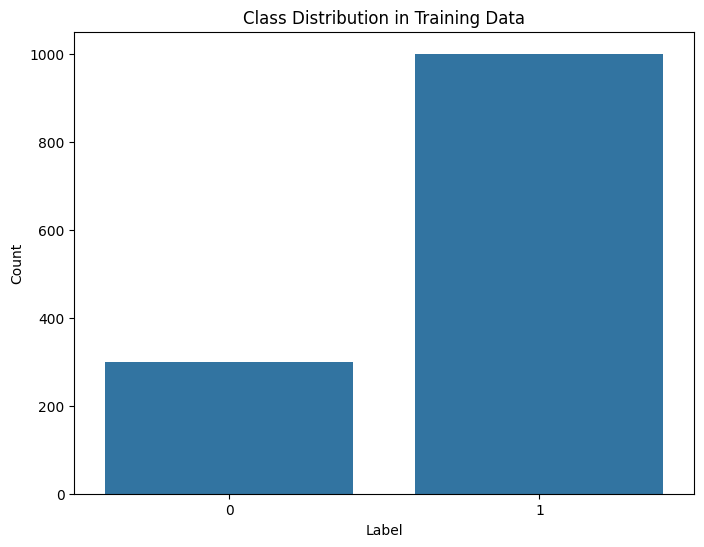

In [ ]:
# Plot the distribution of the classes (labels) in the training data.
# This helps to understand whether the dataset is balanced or if there's a class imbalance.
climate_analysis.plot_class_distribution()


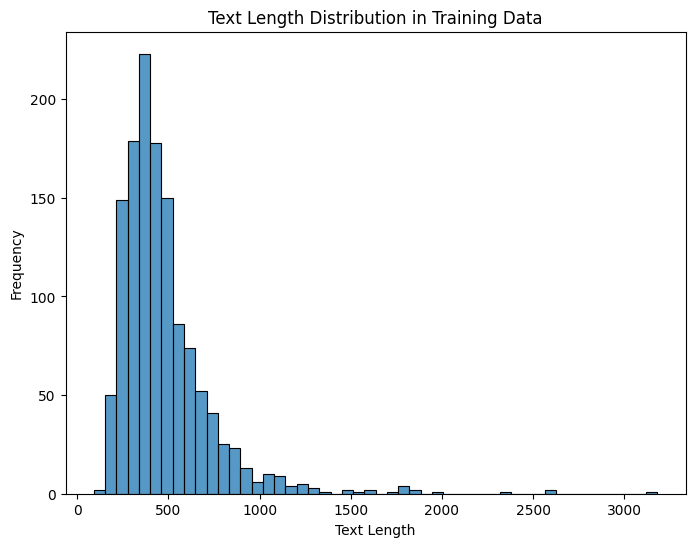

In [ ]:
# Plot the distribution of text lengths in the training data.
# Understanding text length distribution helps in preprocessing, like padding and truncation.
climate_analysis.plot_text_length_distribution()

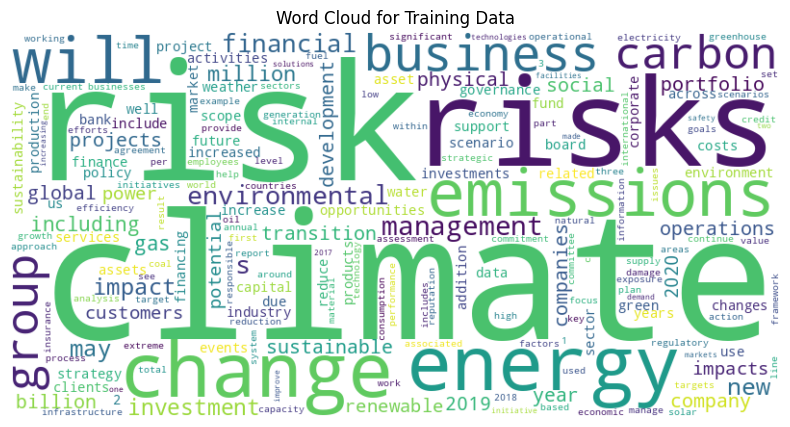

In [ ]:
# Generate a word cloud for the entire training dataset.
# A word cloud visually represents the most common words in the dataset, providing insight into the prevalent topics.
climate_analysis.generate_word_cloud()


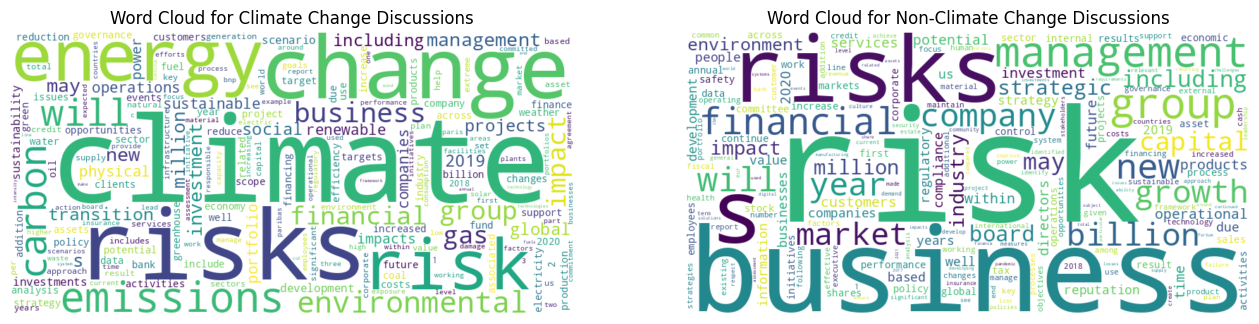

In [ ]:
# Generate separate word clouds for texts labeled as discussing climate change and those that are not.
# This allows you to compare the most frequent words used in climate-related and non-climate-related texts.
climate_analysis.generate_label_word_clouds()


In [ ]:

# Analyze the occurrence of specific keywords in climate-related and non-climate-related texts.
# This step provides a quantitative measure of how often key terms appear in different contexts.
climate_analysis.keyword_stats()


Keyword 'climate':
  - Appears in 42.20% of climate change texts
  - Appears in 0.67% of non-climate change texts
------------------------------
Keyword 'warming':
  - Appears in 2.20% of climate change texts
  - Appears in 0.00% of non-climate change texts
------------------------------
Keyword 'emissions':
  - Appears in 22.70% of climate change texts
  - Appears in 0.00% of non-climate change texts
------------------------------
Keyword 'carbon':
  - Appears in 25.40% of climate change texts
  - Appears in 0.00% of non-climate change texts
------------------------------
Keyword 'energy':
  - Appears in 24.80% of climate change texts
  - Appears in 2.00% of non-climate change texts
------------------------------
Keyword 'sustainability':
  - Appears in 8.40% of climate change texts
  - Appears in 1.00% of non-climate change texts
------------------------------


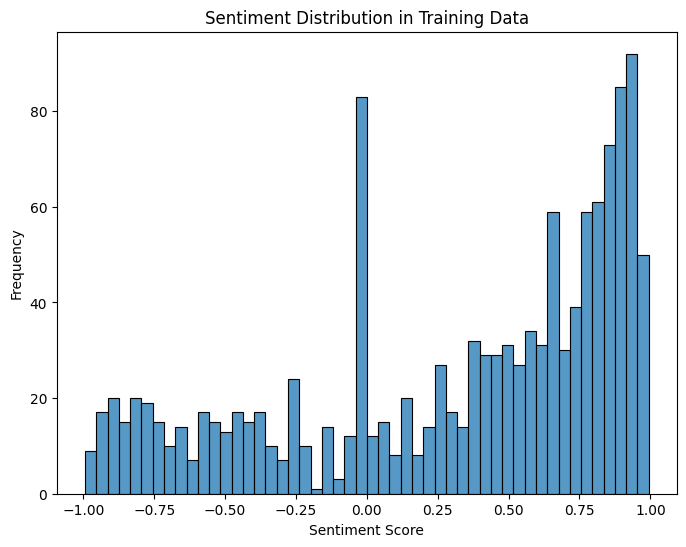

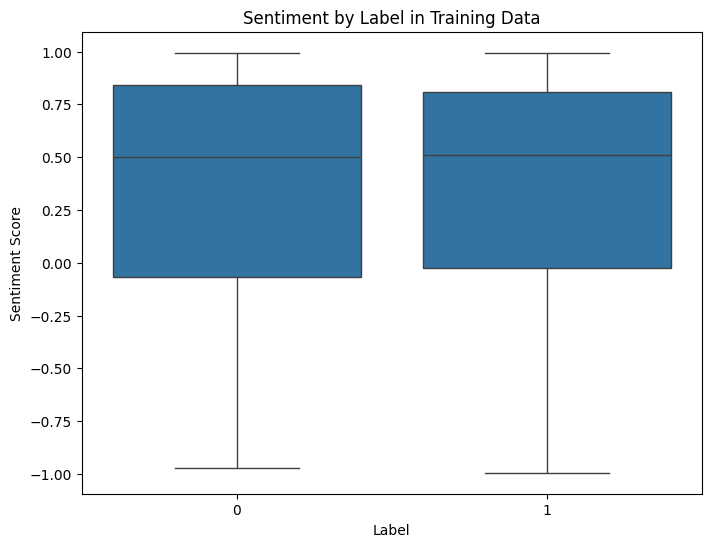

In [ ]:
# Perform sentiment analysis on the training and test datasets, then plot the results.
# Sentiment analysis assigns a sentiment score to each text, indicating whether the text is positive, negative, or neutral.
climate_analysis.analyze_sentiment()


label  sentiment_cat
0      Negative         0.253333
       Neutral          0.073333
       Positive         0.673333
1      Negative         0.244000
       Neutral          0.074000
       Positive         0.682000
Name: text, dtype: float64


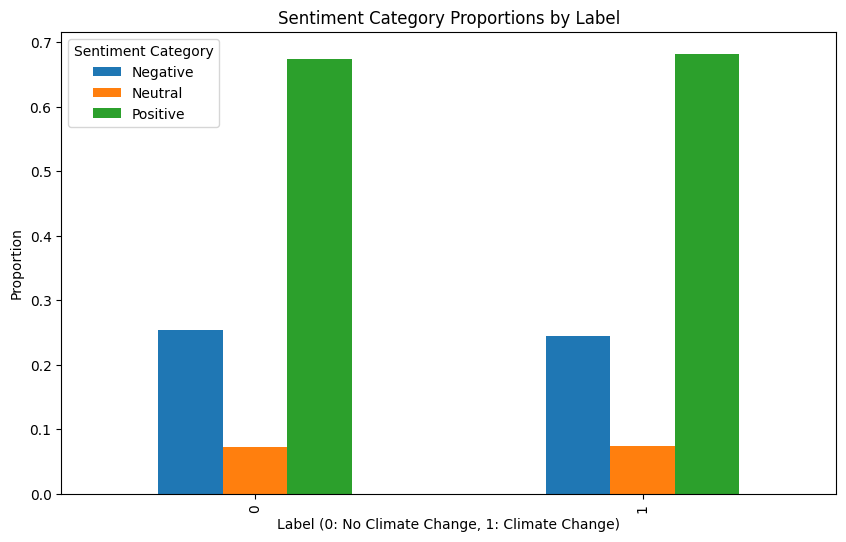

In [ ]:
# Categorize the sentiment scores into Positive, Negative, or Neutral,
# and analyze the distribution of these sentiment categories by label (climate-related or not).
# This helps in understanding the general sentiment trends within the dataset.
climate_analysis.categorize_and_analyze_sentiment()



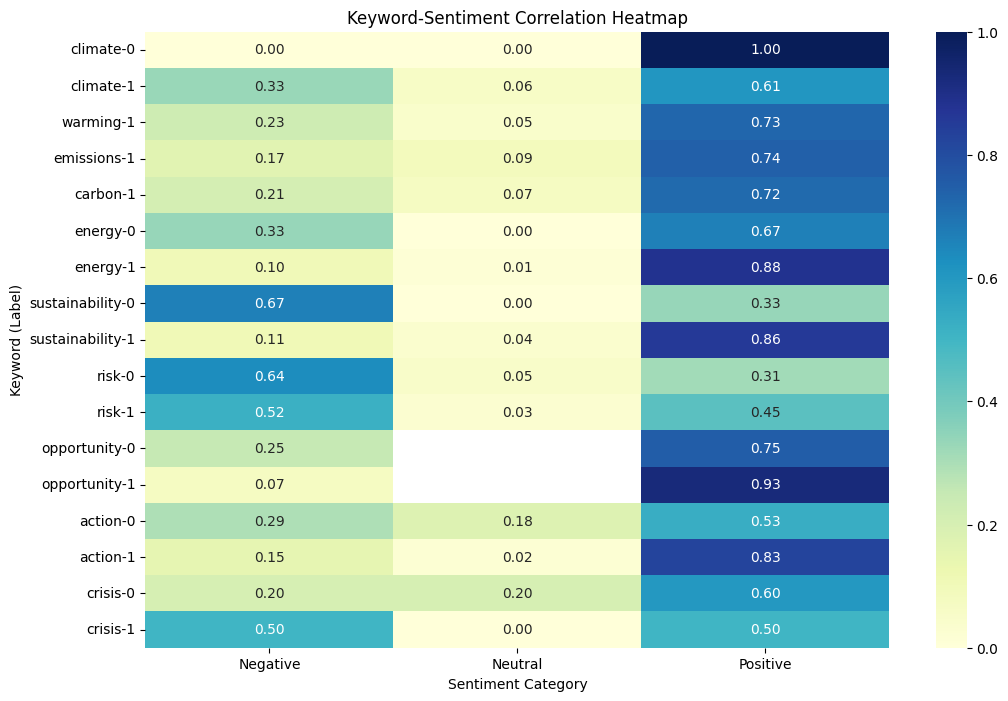

In [ ]:
# Analyze the relationship between specific keywords and sentiment in the training data.
# This step investigates how certain keywords correlate with different sentiment categories, providing deeper insights into the data.
climate_analysis.keyword_sentiment_analysis()


In [ ]:
# Train a BERT-based classifier on the training data.
# The classifier is used to predict whether a given text is related to climate change or not.
# The trained model is saved to the specified directory for later use.
climate_analysis.train_classifier()

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.124601,0.965000,0.987261,0.968750,0.977918
2,No log,0.178543,0.960000,0.972050,0.978125,0.975078
3,No log,0.405424,0.930000,0.989933,0.921875,0.954693
4,0.149000,0.205565,0.962500,0.978056,0.975000,0.976526
5,0.149000,0.226536,0.960000,0.981013,0.968750,0.974843


Model saved at './content/saved_model'.


<ipython-input-3-0c30143e1fb9>:324: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Text: Climate change is a major issue that needs to be addressed.
Predicted Sentiment: Positive

Text: Renewable energy sources are the future.
Predicted Sentiment: Positive

Text: Google company is the one of the top company in the world 
Predicted Sentiment: Negative

Text: harsha is a good boy
Predicted Sentiment: Negative

Text: Climate change is a direct effect of global warming
Predicted Sentiment: Positive

Text: business is very low in the moment
Predicted Sentiment: Negative



Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Evaluation Results: {'test_loss': 0.2619690001010895, 'test_runtime': 11.8169, 'test_samples_per_second': 33.85, 'test_steps_per_second': 4.231}


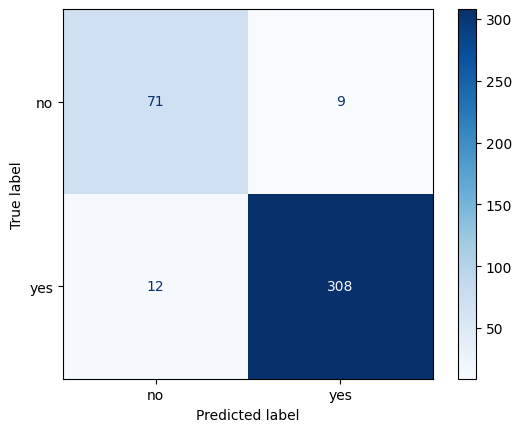

In [ ]:
# Define a list of sample texts for sentiment prediction.
# These texts are inputs for the model to predict whether they discuss climate change and their sentiment.
sample_texts = [
    "Climate change is a major issue that needs to be addressed.",
    "Renewable energy sources are the future.",
    "Google company is the one of the top company in the world ",
    "harsha is a good boy",
    "Climate change is a direct effect of global warming",
    "business is very low in the moment",


]

# Use the trained classifier to predict the sentiment of the sample texts.
# This demonstrates the model's ability to classify new, unseen texts.
climate_analysis.predict_sample_sentiments(sample_texts)

# Evaluate the trained classifier on the test dataset.
# This step involves computing metrics like accuracy, precision, recall, and F1-score, and visualizing the results using a confusion matrix.
climate_analysis.evaluate_classifier()